In [159]:
%matplotlib inline
import pandas as pd
pd.set_option("display.max_rows",999)

import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload

import amr_pcr

## Get and Tidy Data

In [194]:
# read primer data
reload(amr_pcr)

primers = amr_pcr.read_primers('data/primers/tabula-333_primerliste-til-web-07-11-2013-9.tsv')

In [195]:
card = amr_pcr.CARD('CARD/card.json')

for name in primers.CARD_name.unique():
    
    print(card.get_aro_for_name(name))

CARD version 2.0.2
(['TEM-126', 'TEM-72', 'TEM-59', 'TEM-34', 'TEM-7', 'TEM-132', 'TEM-47', 'TEM-16', 'TEM-102', 'TEM-116', 'TEM-109', 'TEM-43', 'TEM-87', 'TEM-183', 'TEM-198', 'TEM-195', 'TEM-77', 'TEM-78', 'TEM-121', 'TEM-138', 'TEM-206', 'TEM-92', 'TEM-158', 'TEM-91', 'TEM-11', 'TEM-67', 'TEM-17', 'TEM-207', 'TEM-176', 'TEM-148', 'TEM-166', 'TEM-1', 'TEM-112', 'TEM-155', 'TEM-122', 'TEM-214', 'TEM-71', 'TEM-33', 'TEM-2', 'TEM-182', 'TEM-22', 'TEM-151', 'TEM-128', 'TEM-191', 'TEM-188', 'TEM-84', 'TEM-52', 'TEM-95', 'TEM-133', 'TEM-106', 'TEM-107', 'TEM-187', 'TEM-110', 'TEM-73', 'TEM-145', 'TEM-201', 'TEM-21', 'TEM-89', 'TEM-162', 'TEM-10', 'TEM-120', 'TEM-159', 'TEM-205', 'TEM-213', 'TEM-192', 'TEM-30', 'TEM-217', 'TEM-6', 'TEM-55', 'TEM-171', 'TEM-26', 'TEM-113', 'TEM-83', 'TEM-68', 'TEM-163', 'TEM-142', 'TEM-42', 'TEM-185', 'TEM-63', 'TEM-49', 'TEM-152', 'TEM-125', 'TEM-88', 'TEM-137', 'TEM-96', 'TEM-153', 'TEM-209', 'TEM-29', 'TEM-28', 'TEM-136', 'TEM-118', 'TEM-20', 'TEM-169', '

(['vanXYC', 'vanXA', 'vanXYG', 'vanXYN', 'vanXYE', 'vanXF', 'vanXD', 'vanXB', 'vanXO', 'vanXYL', 'vanXM', 'vanXI'], ['3002966', '3002949', '3003069', '3002969', '3002967', '3002952', '3003070', '3002950', '3002954', '3002968', '3002953', '3003725'])
(['ErmA'], ['3000347'])
(['ErmB'], ['3000375'])
(['ErmC'], ['3000250'])
(['ErmE'], ['3000326'])
(['ErmF'], ['3000498'])
(['vatA'], ['3002840'])
(['vatB'], ['3002841'])
(['vatD'], ['3002843'])
(['vatE'], ['3002844'])
(['vgaA'], ['3002829'])
(['vgaB'], ['3000118'])
(['vgbA'], ['3001307'])
(['vgbB'], ['3001308'])


In [88]:
!mkdir -p vaware_canonical
with open('run_vaware_canonical.sh', 'w') as fh:
    iter_rows = primers.iterrows()
    for ix, row in iter_rows:
        name = row.loc['Primer name'].replace(" ", "_")
        name = re.escape(name)
        forward = row.loc['Sequence_tidy']
        ix, reverse = next(iter_rows)
        reverse = reverse.loc['Sequence_tidy']
        fh.write("VAware/build/vaware -t 3 -i CARD/nucleotide_fasta_protein_homolog_model.fasta -f {} -r {} > vaware_canonical/{}\n".format(forward, reverse, name))

In [82]:
!bash run_vaware_canonical.sh

In [10]:
!mkdir -p vaware_all_prot_nt
!cat CARD/nucleotide_fasta_protein_* CARD_prevalence/nucleotide_fasta_protein_*_variants.fasta > all_CARD_nt.fasta
with open('run_vaware_all.sh', 'w') as fh:
    iter_rows = primers.iterrows()
    for ix, row in iter_rows:
        name = row.loc['Primer name'].replace(" ", "_")
        name = re.escape(name)
        forward = row.loc['Sequence_tidy']
        ix, reverse = next(iter_rows)
        reverse = reverse.loc['Sequence_tidy']
        fh.write("VAware/build/vaware -t 2 -i  all_CARD_nt.fasta -f {} -r {} > vaware_all_prot_nt/{}\n".format(forward, reverse, name))
        fh.write('echo "{} done"\n'.format(name))

In [1]:
import os
for vaware_out in os.listdir('vaware_canonical'):
    df = pd.read_csv(vaware_out, sep='\t')

NameError: name 'pd' is not defined

In [2]:
df_full = pd.read_csv('vaware_all/NDM-F', sep='\t', comment='#', skiprows=5)

def get_name(id_val):
    if id_val.startswith('Prevalence_Sequence_ID'):
        return id_val.split('|')[1].replace('ARO_Name:', '')
    else:
        return id_val.split('|')[5]
        
def get_type(id_val):
    if id_val.startswith('Prevalence_Sequence_ID'):
        return 'Prevalence'
    else:
        return 'Canonical'
    
df_full['Name'] = df_full['SILVA ID'].apply(get_name)
df_full['Type'] = df_full['SILVA ID'].apply(get_type)

df = df_full[df_full['SILVA ID'].str.contains('NDM')]

df.size

697

In [5]:
df.loc[(df['FP Mismatches'] == 0) & (df['RP Mismatches'] == 0), 'PCR'] = 'Perfect'

In [20]:
df = df.sort_values('Name', )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

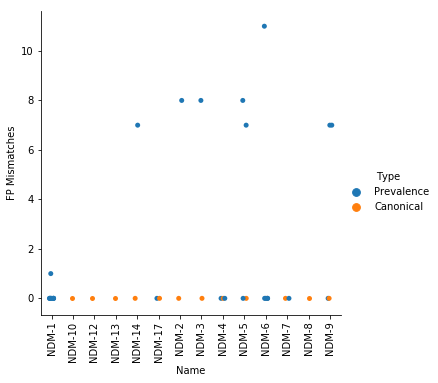

In [21]:
g = sns.catplot(x="Name", y="FP Mismatches", hue="Type", data=df)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

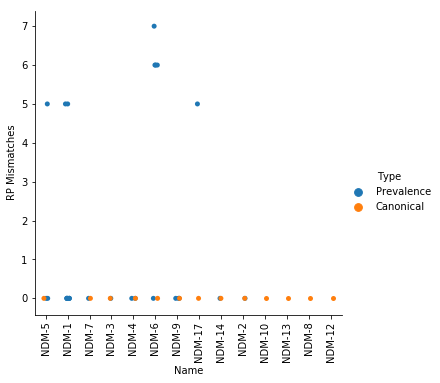

In [18]:
g = sns.catplot(x="Name", y="RP Mismatches", hue="Type", data=df)
plt.xticks(rotation=90)

In [71]:
df_nonndm = df_full[~df_full['SILVA ID'].str.contains('NDM')]

In [72]:

for ix in range(0, 10):
    df = df_nonndm[(df_nonndm['FP Mismatches'] < ix) & (df_nonndm['RP Mismatches'] < ix) & (df_nonndm['Insert Length'] <= 1000)]
    print(ix, df['Name'].value_counts())

0 Series([], Name: Name, dtype: int64)
1 Series([], Name: Name, dtype: int64)
2 Series([], Name: Name, dtype: int64)
3 acrB    41
patA     7
Name: Name, dtype: int64
4 adeJ          212
farA           96
acrB           53
adeF           34
patA           13
Salmonella      8
mdsB            2
VIM-34          1
emrR            1
acrD            1
MuxA            1
mdtO            1
Name: Name, dtype: int64
5 adeF             245
adeJ             238
farA              96
mdtN              80
acrB              61
bacA              27
msrC              26
Escherichia       25
patA              25
mdtB              21
pmrA              21
oqxB              17
mexY              14
lsaA              13
adeB               8
acrD               8
Salmonella         8
mexN               7
vgaA               7
mexQ               5
msbA               5
CTX-M-117          4
vanYB              4
cpxA               4
ceoB               4
CTX-M-42           3
CTX-M-88           3
CTX-M-156          3
C

In [70]:
df['Name'].value_counts()

NDM-1     10
NDM-6      6
NDM-9      4
NDM-5      4
NDM-4      3
NDM-17     2
NDM-7      2
NDM-3      2
NDM-14     2
NDM-2      2
NDM-10     1
NDM-12     1
NDM-8      1
NDM-13     1
Name: Name, dtype: int64